# Match-TTSG: UNIFIED SPEECH AND GESTURE SYNTHESIS USING FLOW MATCHING
---
[Shivam Mehta](https://www.kth.se/profile/smehta), [Ruibo Tu](https://www.kth.se/profile/ruibo), [Simon Alexanderson
](https://www.kth.se/profile/simonal?l=en) [Jonas Beskow](https://www.kth.se/profile/beskow), [Éva Székely](https://www.kth.se/profile/szekely), and [Gustav Eje Henter](https://people.kth.se/~ghe/)

As text-to-speech technologies achieve remarkable naturalness in read-aloud tasks, there is growing interest in multimodal synthesis of verbal and non-verbal communicative behaviour, such as spontaneous speech and associated body gestures. This paper presents a novel, unified architecture for jointly synthesising speech acoustics and skeleton-based 3D gesture motion from text, trained using optimal-transport conditional flow matching (OT-CFM). The proposed architecture is simpler than the previous state of the art, has a smaller memory footprint, and can capture the joint distribution of speech and gestures, generating both modalities together in one single process. The new training regime, meanwhile, enables better synthesis quality in much fewer steps (network evaluations) than before. Uni- and multimodal subjective tests demonstrate improved speech naturalness, gesture human-likeness, and cross-modal appropriateness compared to existing benchmarks.

Demo Page: https://shivammehta25.github.io/Match-TTSG \
Code: https://github.com/shivammehta25/Match-TTSG




In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import datetime as dt
import warnings
from pathlib import Path

import ffmpeg
import IPython.display as ipd
import joblib as jl
import numpy as np
import soundfile as sf
import torch
from tqdm.auto import tqdm

# Hifigan imports
from match_ttsg.hifigan.config import v1
from match_ttsg.hifigan.denoiser import Denoiser
from match_ttsg.hifigan.env import AttrDict
from match_ttsg.hifigan.models import Generator as HiFiGAN
# MatchTTSG imports
from match_ttsg.models.match_ttsg import MatchTTSG
from match_ttsg.text import sequence_to_text, text_to_sequence
from match_ttsg.utils.model import denormalize
from match_ttsg.utils.utils import get_user_data_dir, intersperse

# Motion visualisation imports
from pymo.preprocessing import MocapParameterizer
from pymo.viz_tools import render_mp4
from pymo.writers import BVHWriter

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# This allows for real time code changes being reflected in the notebook, no need to restart the kernel

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Filepaths

In [5]:
MATCHTTSG_CHECKPOINT = "logs/train/synthetic_trimodal_light/runs/2024-03-20_20-37-38/checkpoints/last.ckpt"
MOTION_PIPELINE = "data/synthetic_trimodal/expmaps/data_pipe.expmap_86.1328125fps.sav"
HIFIGAN_CHECKPOINT = get_user_data_dir() / "hifigan_univ_v1"
OUTPUT_FOLDER = "synth_output"

## Load Match-TTSG

In [6]:
def load_model(checkpoint_path):
    model = MatchTTSG.load_from_checkpoint(checkpoint_path, map_location=device)
    model.eval()
    return model
count_params = lambda x: f"{sum(p.numel() for p in x.parameters()):,}"


model = load_model(MATCHTTSG_CHECKPOINT)
print(f"Model loaded! Parameter count: {count_params(model)}")

Model loaded! Parameter count: 22,479,611


## Load HiFi-GAN (Vocoder)

In [7]:
def load_vocoder(checkpoint_path):
    h = AttrDict(v1)
    hifigan = HiFiGAN(h).to(device)
    hifigan.load_state_dict(torch.load(checkpoint_path, map_location=device)['generator'])
    _ = hifigan.eval()
    hifigan.remove_weight_norm()
    return hifigan

vocoder = load_vocoder(HIFIGAN_CHECKPOINT)
denoiser = Denoiser(vocoder, mode='zeros')

/home/smehta/anaconda3/envs/match_ttsg_repo/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


# Load motion visualiser

In [8]:
motion_pipeline = jl.load(MOTION_PIPELINE)
bvh_writer = BVHWriter()
mocap_params = MocapParameterizer("position")

/home/smehta/anaconda3/envs/match_ttsg_repo/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 0.24.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Helper functions to synthesise

In [9]:
@torch.inference_mode()
def process_text(text: str):
    x = torch.tensor(intersperse(text_to_sequence(text, ['english_cleaners2']), 0),dtype=torch.long, device=device)[None]
    x_lengths = torch.tensor([x.shape[-1]],dtype=torch.long, device=device)
    x_phones = sequence_to_text(x.squeeze(0).tolist())
    return {
        'x_orig': text,
        'x': x,
        'x_lengths': x_lengths,
        'x_phones': x_phones
    }


@torch.inference_mode()
def synthesise(text, spks=None):
    text_processed = process_text(text)
    start_t = dt.datetime.now()
    output = model.synthesise(
        text_processed['x'], 
        text_processed['x_lengths'],
        n_timesteps=n_timesteps,
        temperature=temperature,
        spks=spks,
        length_scale=length_scale
    )
    # merge everything to one dict    
    output.update({'start_t': start_t, **text_processed})
    return output

@torch.inference_mode()
def to_waveform(mel, vocoder):
    audio = vocoder(mel).clamp(-1, 1)
    audio = denoiser(audio.squeeze(0), strength=0.00025).cpu().squeeze()
    return audio.cpu().squeeze()


def to_bvh(motion):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return motion_pipeline.inverse_transform([motion.cpu().squeeze(0).T])
    
def save_to_folder(filename: str, output: dict, folder: str):
    folder = Path(folder)
    folder.mkdir(exist_ok=True, parents=True)
    np.save(folder / f'{filename}', output['mel'].cpu().numpy())
    sf.write(folder / f'{filename}.wav', output['waveform'], 22050, 'PCM_24')
    with open(folder / f'{filename}.bvh', 'w') as f:
        bvh_writer.write(output['bvh'], f)

def to_stick_video(filename, bvh, folder):
    folder = Path(folder)
    folder.mkdir(exist_ok=True, parents=True)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        X_pos = mocap_params.fit_transform([bvh])
    print(f"rendering {filename} ...")
    render_mp4(X_pos[0], folder / f'{filename}.mp4', axis_scale=200)


def combine_audio_video(filename: str, folder: str):
    print("Combining audio and video")
    folder = Path(folder)
    folder.mkdir(exist_ok=True, parents=True)

    input_video = ffmpeg.input(str(folder / f'{filename}.mp4'))
    input_audio = ffmpeg.input(str(folder / f'{filename}.wav'))
    output_filename = folder / f'{filename}_audio.mp4'
    ffmpeg.concat(input_video, input_audio, v=1, a=1).output(str(output_filename)).run(overwrite_output=True)
    print(f"Final output with audio: {output_filename}")
    

## Setup text to synthesise

In [11]:
texts = [
    "Um, so, you know, it's kind of like, when you're standing there, right at the edge of something really, really big, and you're just.. just about to take that step, that leap, and there's this, uh, this moment where everything just ... just stops, and you're holding your breath, waiting to see what happens next.",
    "Oh, and the music, you know, it was just perfect. It's like, the score just perfectly captured the mood of every scene, enhancing the story in such a powerful way, and it's like, I'm still humming the tunes, and it's... it's just so, so memorable."


    
]

### Hyperparameters

In [16]:
## Number of ODE Solver steps
n_timesteps = 500

## Changes to the speaking rate
length_scale=1.0

## Sampling temperature
temperature = 0.667

## Speaker
speaker_id = 1

## Synthesis

  0%|          | 0/2 [00:00<?, ?it/s]

*****************************************************
Input text - 0
-----------------------------------------------------
Um, so, you know, it's kind of like, when you're standing there, right at the edge of something really, really big, and you're just.. just about to take that step, that leap, and there's this, uh, this moment where everything just ... just stops, and you're holding your breath, waiting to see what happens next.
*****************************************************
Phonetised text - 0
-----------------------------------------------------
_ˈ_ʌ_m_,_ _s_ˈ_o_ʊ_,_ _j_u_ː_ _n_ˈ_o_ʊ_,_ _ɪ_t_s_ _k_ˈ_a_ɪ_n_d_ _ʌ_v_ _l_ˈ_a_ɪ_k_,_ _w_ˌ_ɛ_n_ _j_ʊ_ɹ_ _s_t_ˈ_æ_n_d_ɪ_ŋ_ _ð_ˈ_ɛ_ɹ_,_ _ɹ_ˈ_a_ɪ_t_ _æ_t_ _ð_ɪ_ _ˈ_ɛ_d_ʒ_ _ʌ_v_ _s_ˈ_ʌ_m_θ_ɪ_ŋ_ _ɹ_ˈ_i_ə_l_i_,_ _ɹ_ˈ_i_ə_l_i_ _b_ˈ_ɪ_ɡ_,_ _æ_n_d_ _j_ʊ_ɹ_ _d_ʒ_ˈ_ʌ_s_t_._._ _d_ʒ_ˈ_ʌ_s_t_ _ɐ_b_ˌ_a_ʊ_t_ _t_ə_ _t_ˈ_e_ɪ_k_ _ð_æ_t_ _s_t_ˈ_ɛ_p_,_ _ð_æ_t_ _l_ˈ_i_ː_p_,_ _æ_n_d_ _ð_ɛ_ɹ_z_ _ð_ˈ_ɪ_s_,_ _ˈ_ʌ_,_ _ð_ɪ_s_ _m_ˈ_o_ʊ_m_ə_n_t_ _w_ˌ_ɛ_ɹ_ _ˈ_ɛ_v_ɹ

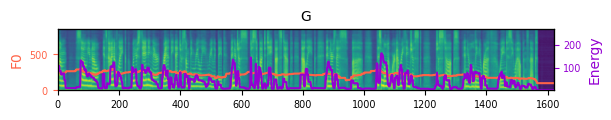

*****************************************************
Input text - 1
-----------------------------------------------------
Oh, and the music, you know, it was just perfect. It's like, the score just perfectly captured the mood of every scene, enhancing the story in such a powerful way, and it's like, I'm still humming the tunes, and it's... it's just so, so memorable.
*****************************************************
Phonetised text - 1
-----------------------------------------------------
_ˈ_o_ʊ_,_ _æ_n_d_ _ð_ə_ _m_j_ˈ_u_ː_z_ɪ_k_,_ _j_u_ː_ _n_ˈ_o_ʊ_,_ _ɪ_t_ _w_ʌ_z_ _d_ʒ_ˈ_ʌ_s_t_ _p_ɚ_f_ˈ_ɛ_k_t_._ _ɪ_t_s_ _l_ˈ_a_ɪ_k_,_ _ð_ə_ _s_k_ˈ_o_ː_ɹ_ _d_ʒ_ˈ_ʌ_s_t_ _p_ˈ_ɜ_ː_f_ɛ_k_t_l_i_ _k_ˈ_æ_p_t_ʃ_ɚ_d_ _ð_ə_ _m_ˈ_u_ː_d_ _ʌ_v_ _ˈ_ɛ_v_ɹ_i_ _s_ˈ_i_ː_n_,_ _ɛ_n_h_ˈ_æ_n_s_ɪ_ŋ_ _ð_ə_ _s_t_ˈ_o_ː_ɹ_i_ _ɪ_n_ _s_ˈ_ʌ_t_ʃ_ _ɐ_ _p_ˈ_a_ʊ_ɚ_f_ə_l_ _w_ˈ_e_ɪ_,_ _æ_n_d_ _ɪ_t_s_ _l_ˈ_a_ɪ_k_,_ _a_ɪ_m_ _s_t_ˈ_ɪ_l_ _h_ˈ_ʌ_m_ɪ_ŋ_ _ð_ə_ _t_ˈ_u_ː_n_z_,_ _æ_n_d_ _ɪ_t_s_._._._ _ɪ_t_s_ _d_ʒ_ˈ_ʌ_s_t_ _s_ˈ_o_ʊ_,_ _s_ˌ_o_ʊ_

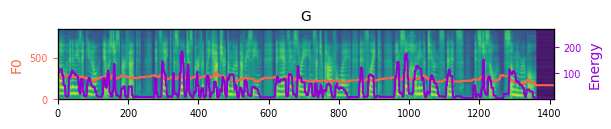

Number of ODE steps: 500
Mean RTF:				0.491606 ± 0.046553
Mean RTF Waveform (incl. vocoder):	0.605104 ± 0.063043


In [17]:
outputs, rtfs = [], []
rtfs_w = []
for i, text in enumerate(tqdm(texts)):
    output = synthesise(text, torch.tensor([speaker_id], device=device, dtype=torch.long))
    output['waveform'] = to_waveform(output['mel'], vocoder)
    output['bvh'] = to_bvh(output['motion'])[0]

    # Compute Real Time Factor (RTF) with HiFi-GAN
    t = (dt.datetime.now() - output['start_t']).total_seconds()
    rtf_w = t * 22050 / (output['waveform'].shape[-1])

    ## Pretty print
    print(f"{'*' * 53}")
    print(f"Input text - {i}")
    print(f"{'-' * 53}")
    print(output['x_orig'])
    print(f"{'*' * 53}")
    print(f"Phonetised text - {i}")
    print(f"{'-' * 53}")
    print(output['x_phones'])
    print(f"{'*' * 53}")
    print(f"RTF:\t\t{output['rtf']:.6f}")
    print(f"RTF Waveform:\t{rtf_w:.6f}")
    rtfs.append(output['rtf'])
    rtfs_w.append(rtf_w)
    outputs.append(output)
    model.plot_mel([(output['decoder_outputs_mel'].cpu().squeeze(), output['pitch_pred'].cpu().squeeze(), output['energy_pred'].cpu().squeeze())], f"Gen_{i}", show=True)
    

    ## Display the synthesised waveform
    ipd.display(ipd.Audio(output['waveform'], rate=22050))

    ## Save the generated waveform
    save_to_folder(i, output, OUTPUT_FOLDER)

print(f"Number of ODE steps: {n_timesteps}")
print(f"Mean RTF:\t\t\t\t{np.mean(rtfs):.6f} ± {np.std(rtfs):.6f}")
print(f"Mean RTF Waveform (incl. vocoder):\t{np.mean(rtfs_w):.6f} ± {np.std(rtfs_w):.6f}")

In [18]:
outputs[0].keys()

dict_keys(['encoder_outputs_mel', 'decoder_outputs_mel', 'encoder_outputs_motion', 'decoder_outputs_motion', 'attn', 'mel', 'motion', 'pitch_pred', 'energy_pred', 'mel_lengths', 'rtf', 'start_t', 'x_orig', 'x', 'x_lengths', 'x_phones', 'waveform', 'bvh'])

In [19]:
for i, output in enumerate(tqdm(outputs)):
    to_stick_video(i, output['bvh'], OUTPUT_FOLDER)
    combine_audio_video(i, OUTPUT_FOLDER)

  0%|          | 0/2 [00:00<?, ?it/s]

MocapParameterizer: position
rendering 0 ...


/home/smehta/Projects/Match-TTSG/pymo/viz_tools.py:168: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_x = data["%s_Xposition" % joint][frame]
/home/smehta/Projects/Match-TTSG/pymo/viz_tools.py:169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_y = data["%s_Yposition" % joint][frame]
/home/smehta/Projects/Match-TTSG/pymo/viz_tools.py:170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_z = data["%s_Zposition" % joi

Combining audio and video


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Final output with audio: synth_output/0_audio.mp4
MocapParameterizer: position
rendering 1 ...


/home/smehta/Projects/Match-TTSG/pymo/viz_tools.py:168: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_x = data["%s_Xposition" % joint][frame]
/home/smehta/Projects/Match-TTSG/pymo/viz_tools.py:169: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_y = data["%s_Yposition" % joint][frame]
/home/smehta/Projects/Match-TTSG/pymo/viz_tools.py:170: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  parent_z = data["%s_Zposition" % joi

Combining audio and video


ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

Final output with audio: synth_output/1_audio.mp4


frame=  493 fps=277 q=-1.0 Lsize=     489kB time=00:00:16.39 bitrate= 244.5kbits/s speed=9.21x    
video:340kB audio:135kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.054142%
[aac @ 0x55c7af189040] Qavg: 2538.666
[libx264 @ 0x55c7af18a980] frame I:2     Avg QP:11.99  size: 57719
[libx264 @ 0x55c7af18a980] frame P:127   Avg QP:22.34  size:   927
[libx264 @ 0x55c7af18a980] frame B:364   Avg QP:26.44  size:   313
[libx264 @ 0x55c7af18a980] consecutive B-frames:  1.0%  1.2%  1.2% 96.6%
[libx264 @ 0x55c7af18a980] mb I  I16..4: 55.9% 17.8% 26.3%
[libx264 @ 0x55c7af18a980] mb P  I16..4:  0.0%  0.0%  0.0%  P16..4:  0.2%  0.2%  0.4%  0.0%  0.0%    skip:99.3%
[libx264 @ 0x55c7af18a980] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  0.1%  0.2%  0.2%  direct: 0.1%  skip:99.4%  L0:41.9% L1:39.7% BI:18.4%
[libx264 @ 0x55c7af18a980] 8x8 transform intra:17.7% inter:15.4%
[libx264 @ 0x55c7af18a980] coded y,uvDC,uvAC intra: 22.1% 2.3% 2.2% inter: 0.2% 0.2% 0.2%
[libx264 @ 0x55c7af18a